# Computer Vision 2025-2026 - NOVA FCT

### Lab 9 - Inference and Evaluation of Object Detectors - YOLO & DETR - 14/November

**Lecturers**:
   - David Semedo <df.semedo@fct.unl.pt>
   - Rui Nóbrega <rui.nobrega@fct.unl.pt>

## Required Libraries

Install the following libraries to load YOLO and DETR models:

In [1]:
!pip install datasets transformers timm wandb matplotlib albumentations
!pip install pycocotools
!pip install torchmetrics
!pip install ultralytics
!pip install supervision
!pip install roboflow


In [114]:
# Importing the required libraries
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [115]:
import torch
from ultralytics import YOLO
from transformers import pipeline

## Inference with YOLO Models

You can load a pretrained YOLO model using the `YOLO()` class from the `ultralytics` package. Choose one of the model variants (for example "yolo11n.pt" or "yolo11s.pt") depending on your desired trade‑off between speed, size and accuracy:

<img src="models.png" alt="description" width="640">

The official documentation provides detailed performance metrics for each variant:  
[YOLO11 Performance Metrics](https://docs.ultralytics.com/models/yolo11/#performance-metrics)

#### The predict function
The `model.predict()` method is used to run object detection on images, videos, or image batches. You can control various aspects of detection using its parameters. Below are some of the most commonly used ones:

#### Parameters

- **`conf`** (`float`, default=`0.25`)  
  Sets the **minimum confidence threshold** for detections. YOLO will disregard any objects detected with a confidence score below this value.  
  - **Example:** Setting `conf=0.5` will only return detections that the model is at least 50% confident about.  
  - **Use case:** Increasing this value can reduce false positives, while lowering it can help detect objects that are less obvious.

- **`iou`** (`float`, default=`0.7`)  
  Determines the **Intersection Over Union (IoU) threshold** for **Non-Maximum Suppression (NMS)**. NMS eliminates overlapping bounding boxes that likely correspond to the same object.  
  - **Example:** `iou=0.5` will remove boxes that overlap more than 50% with a higher-confidence box.  
  - **Use case:** Lowering the IoU can reduce duplicate detections, but too low may remove legitimate overlapping objects.

- **`imgsz`** (`int` or `tuple`, default=`640`)  
  Specifies the **image size used for inference**.  
  - Can be a single integer (e.g., `640`) for square resizing, or a tuple `(height, width)` for custom resizing.  
  - **Use case:** Proper resizing can improve both **accuracy** and **processing speed**. Larger sizes may improve detection of small objects but increase inference time.


In [116]:
# Load a model
yolo_model = YOLO("yolo11s.pt")  # pretrained YOLO11s model (small)

# Run batched inference on a list of images
results = yolo_model.predict(["stock-boygirl.jpg", "cars.png"], 
                        conf=0.25,     # minimum confidence
                        iou=0.5,      # NMS threshold
                        imgsz=640     # resize image to 640x640
)

for i, result in enumerate(results):
    boxes = result.boxes  # Boxes object for bounding box outputs
    class_id = int(result.boxes[0].cls)     # class index of the first detected object
    class_name = yolo_model.names[class_id]      # map to class name

    print(f"Length of boxes for image {i}: {len(boxes)}")
    print(f"Class ID of first detected object: {class_id} - name: {yolo_model.names[class_id]}")

    #result.show()  # display to screen
    #result.save(filename="result.jpg")  # save to disk


0: 640x640 2 persons, 1 backpack, 1 handbag, 94.1ms
1: 640x640 3 persons, 23 cars, 4 buss, 1 truck, 94.1ms
Speed: 17.1ms preprocess, 94.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)
Length of boxes for image 0: 4
Class ID of first detected object: 0 - name: person
Length of boxes for image 1: 31
Class ID of first detected object: 5 - name: bus


To understand the output of each boxes and probabilities, refer to the [Results Object Documentation](https://docs.ultralytics.com/modes/predict/#working-with-results).

#### Results visualization.

Let's visualize the results obtained from the model predictions. The `Results` object provides methods to display and save the detection results.

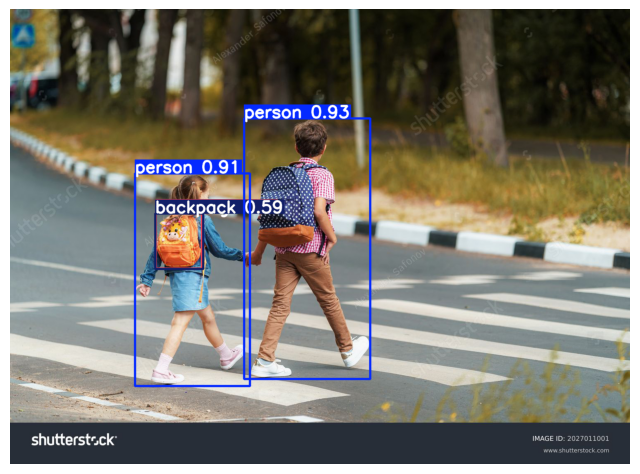

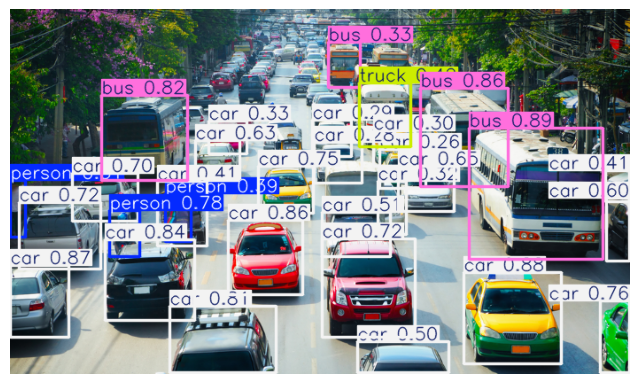

In [117]:
# Visualize the results
for i, r in enumerate(results):
    
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(im_rgb)
    plt.axis("off")  # Hide axes
    plt.show()

    # Save results to disk
    #r.save(filename=f"results{i}.jpg")

## Inference with DETR from Hugging Face Library

The Hugging Face Transformers library provides an easy-to-use **pipeline API** for running object detection with pretrained models like DETR. This allows you to perform inference on images with minimal setup.

Learn about the ObjectDetectionPipeline object here: [ObjectDetectionPipeline](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.ObjectDetectionPipeline). Make sure you go through the different parameters.

#### Explanation

- `pipeline("object-detection", ...)` initializes an **object detection pipeline**. It handles all the necessary steps:
  - Preprocessing the input image
  - Running the DETR model to produce predictions
  - Post-processing outputs into bounding boxes, class labels, and confidence scores

- `model="facebook/detr-resnet-50"` specifies the **pretrained DETR model** with a ResNet-50 backbone provided by Hugging Face.

- The resulting `det_pipeline` object can be used to run inference on any image:
  - It returns a list of detections, where each detection includes:
    - `box` → coordinates of the bounding box
    - `label` → class name
    - `score` → confidence of the prediction

This pipeline allows you to perform object detection **quickly and easily**, without manually handling model inputs, outputs, or post-processing steps.



In [118]:
import warnings
warnings.filterwarnings("ignore", message=".*meta parameter.*")

det_pipeline = pipeline("object-detection", model="facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


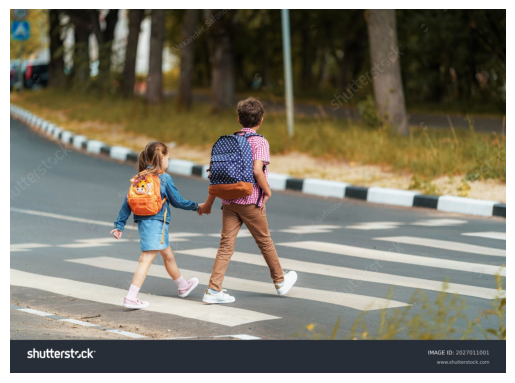

In [119]:
image_path = "stock-boygirl.jpg"
#image_path = "cars.png"

image = cv2.imread(image_path)[:, :, ::-1]  # BGR to RGB

# Convert PIL image to NumPy
image_np = np.array(image)

plt.imshow(image)
plt.axis("off")
plt.show()

Let's invoke the pipeline on an example image, obtain the detections, draw the bounding boxes, and display the results.

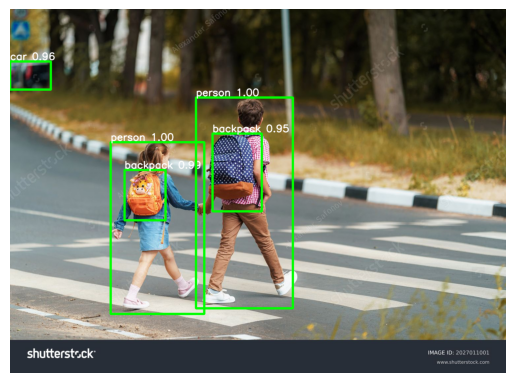

In [120]:
results = det_pipeline(image_path)

for r in results:
    x0, y0, x1, y1 = r['box'].values()
    label = r['label']
    score = r['score']

    # Draw on image with OpenCV
    cv2.rectangle(image_np, (int(x0), int(y0)), (int(x1), int(y1)), (0,255,0), 5)
    cv2.putText(image_np, f"{label} {score:.2f}", (int(x0), int(y0)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2, cv2.LINE_AA)
    
plt.imshow(image_np)
plt.axis("off")
plt.show()

## Evaluation Object Detection

#### Computing COCO-style mAP

COCO-style **Mean Average Precision (mAP)** is the standard metric for object detection. Its computation is based on **Precision–Recall (PR) curves** and averaging AP across multiple IoU thresholds and classes.

---

##### 1. Precision–Recall Curve

For each object class:

- **Precision** measures the fraction of predicted boxes that are correct:
$
\text{Precision} = \frac{TP}{TP + FP}
$

- **Recall** measures the fraction of ground-truth objects that are detected:
$
\text{Recall} = \frac{TP}{TP + FN}
$

Where:

- $ TP $ = True Positives  
- $ FP $ = False Positives  
- $ FN $ = False Negatives  

By varying the **confidence threshold** for predictions, we obtain different precision and recall values, forming the **precision–recall curve**.

---

##### 2. Interpolated Precision

COCO uses **interpolated precision** to smooth the PR curve:

$
p_{\text{interp}}(r) = \max_{\tilde r \ge r} p(\tilde r)
$

- Ensures the curve is **monotonically non-increasing**  
- Stabilizes the calculation of the area under the curve

---

##### 3. Average Precision (AP)

The **Average Precision (AP)** for a class and IoU threshold is the **area under the interpolated precision–recall curve**:

$
AP = \int_0^1 p_{\text{interp}}(r)\, dr
$

In practice, COCO computes this by sampling precision at 101 recall points:

$
AP = \frac{1}{101} \sum_{r \in \{0,0.01, \dots, 1\}} p_{\text{interp}}(r)
$

---

##### 4. Mean Average Precision (mAP)

COCO computes mAP by **averaging AP across multiple IoU thresholds and all object classes**:

- IoU thresholds in COCO: $ \{0.50, 0.55, 0.60, \dots, 0.95\} $ 
- Let \( C \) = number of classes, $ T = 10 $ IoU thresholds

$
mAP = \frac{1}{C} \frac{1}{T} \sum_{c=1}^{C} \sum_{t=1}^{T} AP_{c,t}
$

This metric is referred to as **AP@[.5:.95]**.


**Example of computing Precision and different recall levels, and then taking the average:**

<img src="precision_recall.gif" alt="Object Detection Demo" width="600">


### Computing mAP (Mean Average Precision) with TorchMetrics

In this section, we will use torchmetrics to compute **mAP** for object detection models such as YOLO or DETR.  

The official metric for evaluating object detection models is **mean Average Precision (mAP)**, which summarizes the precision-recall curve across different classes and IoU thresholds.

[TorchMetrics](https://torchmetrics.readthedocs.io/) provides a clean and easy-to-use implementation of **mAP**, suitable for quick evaluation directly within notebooks. Check the documentation of the `MeanAveragePrecision` class for more details: 
[MeanAveragePrecision Documentation](https://lightning.ai/docs/torchmetrics/v1.8.1/detection/mean_average_precision.html#torchmetrics.detection.mean_ap.MeanAveragePrecision)


When providing predictions to `torchmetrics.detection.MeanAveragePrecision`, each dictionary should contain the following fields:

- **boxes**: Predicted bounding boxes in **xyxy format** `(x_min, y_min, x_max, y_max)`.  
- **scores**: Confidence scores for each predicted bounding box.  
- **labels**: Integer class IDs for each box. Must match the class IDs in the ground-truth annotations.

The metric automatically computes per-class Average Precision and averages across classes to get the final mAP.


In [121]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision()

# Example model predictions
predictions = [
    {
        "boxes": torch.tensor([[10, 20, 100, 200]]),  # xyxy format
        "scores": torch.tensor([0.9]),
        "labels": torch.tensor([1])
    }
]

# Example ground truth
targets = [
    {
        "boxes": torch.tensor([[12, 18, 98, 205]]),  # xyxy format
        "labels": torch.tensor([1])
    }
]

# Update metric and compute results
metric.update(predictions, targets)
results = metric.compute()
results


{'map': tensor(0.9000),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(0.9000),
 'mar_1': tensor(0.9000),
 'mar_10': tensor(0.9000),
 'mar_100': tensor(0.9000),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(0.9000),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

#### Understanding TorchMetrics mAP Outputs

When using `torchmetrics.detection.MeanAveragePrecision`, the `compute()` method returns a dictionary containing several evaluation metrics. These follow the COCO evaluation protocol and provide insights into both detection quality and localization accuracy.

Below is a description of the most important keys returned by TorchMetrics:

##### **Primary Metrics**

| Key | Description |
|-----|-------------|
| **map** | **Mean Average Precision averaged over IoU thresholds from 0.50 to 0.95** (step 0.05). This is the standard COCO primary metric, also written as **AP@[.5:.95]**. |
| **map_50** | AP at IoU = 0.50 (also known as AP50). A more lenient metric where coarse localization still counts as correct. |
| **map_75** | AP at IoU = 0.75 (AP75). A stricter metric requiring more accurate bounding boxes. |

##### **Scale-Based Metrics**

| Key | Description |
|-----|-------------|
| **map_small** | AP for small objects only, based on COCO size thresholds. |
| **map_medium** | AP for medium-sized objects. |
| **map_large** | AP for large objects. |

These metrics help diagnose whether a model struggles with detecting objects of specific sizes.

##### **Recall Metrics**

TorchMetrics also provides **mean average recall (MAR)** metrics, which capture how well the model *finds* objects independent of classification confidence thresholds.

| Key | Description |
|-----|-------------|
| **mar_1** | Mean Average Recall for at most 1 detection per image. |
| **mar_10** | Mean Average Recall for up to 10 detections per image. |
| **mar_100** | Mean Average Recall for up to 100 detections per image (COCO default). |
| **mar_small / mar_medium / mar_large** | Recall metrics broken down by object size. |

##### **Summary**

- **`map`** is the key metric: identical to COCO’s AP@[.5:.95].  
- **`map_50` and `map_75`** give insight into bounding-box accuracy.  
- **Size-based metrics** reveal performance differences across object scales.  
- **Recall metrics** evaluate how many ground-truth objects the model is able to retrieve.


## Comparing YOLOv11 and DETR models on a subset of PASCAL VOC 2007

To evaluate and compare the performance of YOLOv11 and DETR models, we will use a small subset of the PASCAL VOC 2007 dataset. This will allow us to compute the mAP for both models on the same data. The first step, is to download the dataset:


1. Download the PASCAL VOC 2007 train+val dataset splits from the following Google Drive link: **[VOC 2007 train+val dataset](https://drive.google.com/file/d/1z7kDDWRCZfy-9_8GWfkLzY980J-RQxcr/view?usp=sharing)**.

2. Place the downloaded file in the `data/` folder of this notebook repository. Your directory structure should look like this:

```text
.
├── YOLO_DETR.ipynb     # This notebook file
└── data
    └── VOCdevkit
        └── VOC2007
            ├── Annotations
            ├── ImageSets
            │   ├── Main
            │   └── Layout
            │   └── Segmentation
            ├── JPEGImages
            ├── SegmentationClass
            └── SegmentationObject


In [122]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.datasets import VOCDetection

In [123]:
# Let's just load the VOC 2007 validation dataset
dataset = VOCDetection('data/', year="2007", image_set="val", download=False)

In [198]:
# We will pick only 5 images.
subset_size = 5
subset = [dataset[i] for i in range(subset_size)]

# Mapping VOC classes to IDs
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
VOC_CLASS_TO_ID = {cls_name: idx+1 for idx, cls_name in enumerate(VOC_CLASSES)}


Before evaluating object detection models using **TorchMetrics**, it is necessary to **prepare the ground-truth annotations** in the correct format.  

- Most datasets, including **Pascal VOC**, store annotations in their own format (VOC uses **XML files**) which contain:
  - Object names (class labels)
  - Bounding boxes (`xmin`, `ymin`, `xmax`, `ymax`)
  - Other metadata (pose, difficult flag, truncated, etc.)
- **TorchMetrics** expects the ground-truth for each image in a **specific dictionary format**:
  ```python
  {
      "boxes": Tensor of shape (num_objects, 4),  # xyxy format
      "labels": Tensor of shape (num_objects,)    # integer class IDs
  }


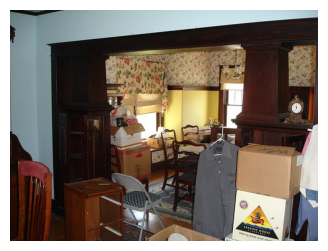

(<PIL.Image.Image image mode=RGB size=500x375>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000005.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '325991873'},
   'owner': {'flickrid': 'archintent louisville', 'name': '?'},
   'size': {'width': '500', 'height': '375', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'chair',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '263', 'ymin': '211', 'xmax': '324', 'ymax': '339'}},
    {'name': 'chair',
     'pose': 'Unspecified',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '165', 'ymin': '264', 'xmax': '253', 'ymax': '372'}},
    {'name': 'chair',
     'pose': 'Unspecified',
     'truncated': '1',
     'difficult': '1',
     'bndbox': {'xmin': '5', 'ymin': '244', 'xmax': '67', 'ymax': '374'}},
    {'name': 'chair',
     'pose': 'Unspecified',
     'truncated': '0',
     '

In [199]:
# Visualize and Inspect one of the images
plt.figure(figsize=(4, 3))
plt.imshow(subset[0][0])
plt.axis("off")
plt.show()

subset[0]

In [200]:
# -----------------------------
# Prepare targets in TorchMetrics format
# -----------------------------
targets_list = []
for img, target in subset:
    objs = target['annotation']['object']
    if not isinstance(objs, list):
        objs = [objs]
    boxes = []
    labels = []
    for obj in objs:
        b = obj['bndbox']
        boxes.append([int(b['xmin']), int(b['ymin']), int(b['xmax']), int(b['ymax'])])
        labels.append(VOC_CLASS_TO_ID[obj['name']])
    targets_list.append({
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    })
targets_list

[{'boxes': tensor([[263., 211., 324., 339.],
          [165., 264., 253., 372.],
          [  5., 244.,  67., 374.],
          [241., 194., 295., 299.],
          [277., 186., 312., 220.]]),
  'labels': tensor([9, 9, 9, 9, 9])},
 {'boxes': tensor([[141.,  50., 500., 330.]]), 'labels': tensor([7])},
 {'boxes': tensor([[ 69., 172., 270., 330.],
          [150., 141., 229., 284.],
          [285., 201., 327., 331.],
          [258., 198., 297., 329.]]),
  'labels': tensor([13, 15, 15, 15])},
 {'boxes': tensor([[ 92.,  72., 305., 473.]]), 'labels': tensor([2])},
 {'boxes': tensor([[231.,  88., 483., 256.],
          [ 11., 113., 266., 259.]]),
  'labels': tensor([8, 8])}]

The code below loops over the targets, and generates dummy predictions, simulating model predictions.

#### **TODO (Exercise 2)**: 

- Replace the dummy predictions with actual model outputs from YOLO and DETR, for the same 5 images, and compute mAP for both models on the selected subset of images.

- The classes that both the YOLO and DETR models predict are different from the Pascal VOC classes. You will need to map the predicted class IDs from both models to the corresponding Pascal VOC class IDs before computing mAP. To do this, you should get the class names from the model predictions, and then use the `VOC_CLASS_TO_ID` dictionary to find the corresponding Pascal VOC class IDs.

In [201]:
# COCO classes for YOLOv11
# Dictionary mapping class IDs to names
COCO_CLASSES = yolo_model.names

In [202]:
import torch
import numpy as np
from ultralytics import YOLO
from transformers import pipeline
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# ------------------------------------------------
# Helper: Convert YOLO outputs to VOC-format dict
# ------------------------------------------------
def convert_yolo_predictions(yolo_results, coco_classes, voc_map):
    yolo_boxes = torch.tensor(yolo_results.boxes.xyxy, dtype=torch.float32)
    yolo_scores = torch.tensor(yolo_results.boxes.conf, dtype=torch.float32)

    # Convert YOLO class indices → names → VOC ids
    labels_list = []
    for label_idx in yolo_results.boxes.cls:
        name = coco_classes[label_idx.item()]
        label_id = voc_map.get(name, 0)
        labels_list.append(label_id)

    yolo_labels = torch.tensor(labels_list, dtype=torch.int64)

    return {
        "boxes": yolo_boxes,
        "scores": yolo_scores,
        "labels": yolo_labels,
    }


# ------------------------------------------------
# Helper: Convert DETR predictions → VOC with threshold
# ------------------------------------------------
def convert_detr_predictions(detr_results, voc_map, confidence=0.1):
    # Filter by confidence
    detr_results = [r for r in detr_results if r["score"] >= confidence]

    if len(detr_results) == 0:
        return None

    boxes_list = []
    scores_list = []
    labels_list = []

    for r in detr_results:
        box = r["box"]

        # Convert to xyxy
        if isinstance(box, dict):
            boxes_list.append([box["xmin"], box["ymin"], box["xmax"], box["ymax"]])
        else:
            x, y, w, h = box
            boxes_list.append([x, y, x + w, y + h])

        scores_list.append(r["score"])
        label_id = voc_map.get(r["label"], 0)
        labels_list.append(label_id)

    return {
        "boxes": torch.tensor(boxes_list, dtype=torch.float32),
        "scores": torch.tensor(scores_list, dtype=torch.float32),
        "labels": torch.tensor(labels_list, dtype=torch.int64),
    }


# ------------------------------------------------
# Evaluate a single sample for both YOLO and DETR
# ------------------------------------------------
def evaluate_sample(img, target, yolo_model, detr_pipeline, coco_classes, voc_map,
                    metric_yolo, metric_detr, confidence=0.1):
    img_np = np.array(img)

    # --- YOLO ---
    yolo_raw = yolo_model(img_np, conf=confidence, verbose=False)[0]
    yolo_preds = convert_yolo_predictions(yolo_raw, coco_classes, voc_map)
    metric_yolo.update([yolo_preds], [target])

    # --- DETR ---
    detr_raw = detr_pipeline(img)
    detr_preds = convert_detr_predictions(detr_raw, voc_map, confidence=confidence)

    if detr_preds is not None:
        metric_detr.update([detr_preds], [target])


# ------------------------------------------------
# Main evaluation loop
# ------------------------------------------------
def evaluate_models(subset, targets_list, coco_classes, voc_map, confidence=0.1):
    # Load models
    yolo_model = YOLO("yolo11s.pt")
    detr_pipeline = pipeline("object-detection", model="facebook/detr-resnet-50")

    # Metrics
    metric_yolo = MeanAveragePrecision()
    metric_detr = MeanAveragePrecision()

    # Loop through samples
    for sample, target in zip(subset, targets_list):
        img = sample[0]
        evaluate_sample(img, target, yolo_model, detr_pipeline,
                        coco_classes, voc_map, metric_yolo, metric_detr, confidence=confidence)

    # Compute
    return metric_yolo.compute(), metric_detr.compute()

In [203]:
yolo_results, detr_results = evaluate_models(subset, targets_list, COCO_CLASSES, VOC_CLASS_TO_ID, confidence=0.1)
yolo_results, detr_results

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


({'map': tensor(0.7839),
  'map_50': tensor(0.9653),
  'map_75': tensor(0.7987),
  'map_small': tensor(-1.),
  'map_medium': tensor(0.3574),
  'map_large': tensor(0.8833),
  'mar_1': tensor(0.6111),
  'mar_10': tensor(0.7867),
  'mar_100': tensor(0.7867),
  'mar_small': tensor(-1.),
  'mar_medium': tensor(0.3625),
  'mar_large': tensor(0.8833),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor([ 0,  2,  4,  7,  8,  9, 13, 15], dtype=torch.int32)},
 {'map': tensor(0.7981),
  'map_50': tensor(0.9525),
  'map_75': tensor(0.7531),
  'map_small': tensor(-1.),
  'map_medium': tensor(0.3839),
  'map_large': tensor(0.8917),
  'mar_1': tensor(0.6278),
  'mar_10': tensor(0.8072),
  'mar_100': tensor(0.8072),
  'mar_small': tensor(-1.),
  'mar_medium': tensor(0.4250),
  'mar_large': tensor(0.8917),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor([ 0,  2,  7,  8,  9, 13, 15], dtype=torch.int32)})

## Lab Questions & Exercises

* Ex1 - Which model (YOLO or DETR) performed better on the 'cars.png', 'stock-boygirl.jpg' and 'lisboa1.jpg"? Justify your answer based on the results obtained.
* Ex2 - Compute mAP for the first 5 images of the VOC 2007 dataset using both YOLO and DETR models. Compare and discuss the results.